In [5]:
# python imports
import os
import time
import functools

import numpy as np
from scipy import stats
from scipy.stats import uniform, norm, t as tdist, ttest_ind


In [6]:
# setup graphs
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib import rc

plt.rcParams['figure.figsize'] = 8, 3.5
plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['figure.dpi'] = 100;

# numpy print format
np.set_printoptions(linewidth=120, precision=4, suppress=False, formatter={'float': '{:5.3e}'.format})

In [7]:
# local imports
import util.tests as tests
import util.dwdb_reader as io
import util.func as f

import DpawsTools

In [180]:
small_value = 1e-300

PROJECT_ROOT_DIR=os.getcwd()
tracenum = 50000
step = 5000
sample_start = 30 # 100  # 40
sample_end =   50 #500    # 180
rlen = sample_end - sample_start

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(IMAGES_PATH): os.makedirs(IMAGES_PATH)

LOG_DIR = os.path.join(PROJECT_ROOT_DIR, "log")
if not os.path.exists(LOG_DIR): os.makedirs(LOG_DIR)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load traces and predictions

In [181]:
print("Reading traces")
# dsr = io.dwdb_reader(r'DPAD_FvR.Traces/RawTraces.dwdb', r'DPAD_FvR.Traces')
dsr = io.dwdb_reader(r'DPAD_AES2.Traces/RawTraces_new.dwdb', r'DPAD_AES2.Traces')
data_batch, meta_batch = dsr.read_batch(tracenum, sample_start, sample_end)
print("Done")

print("Processing data and meta")
# converting data to numpy matrix
data_np = np.asarray(data_batch)

#processing of classifiers
meta_prep = [m['other'].split() for m in meta_batch]
classifiers = [s.split('=')[1] for m in meta_prep for s in m if s.startswith('s=')]
classifiers_np = np.asarray(classifiers)

print("Done")

data_np.shape, classifiers_np.shape

Reading traces
Done
Processing data and meta
Done


((50000L, 20L), (50000L,))

## Sanity check. Make sure it leaks

In [182]:
binave = DpawsTools.Binave(data_np.shape[1], 1)
binave.process(data_np, classifiers_np.tolist())


In [183]:
ave = binave.average() / 100
tt = next(binave.ttests())
ave.shape, tt.shape

((20L,), (20L,))

<IPython.core.display.Javascript object>


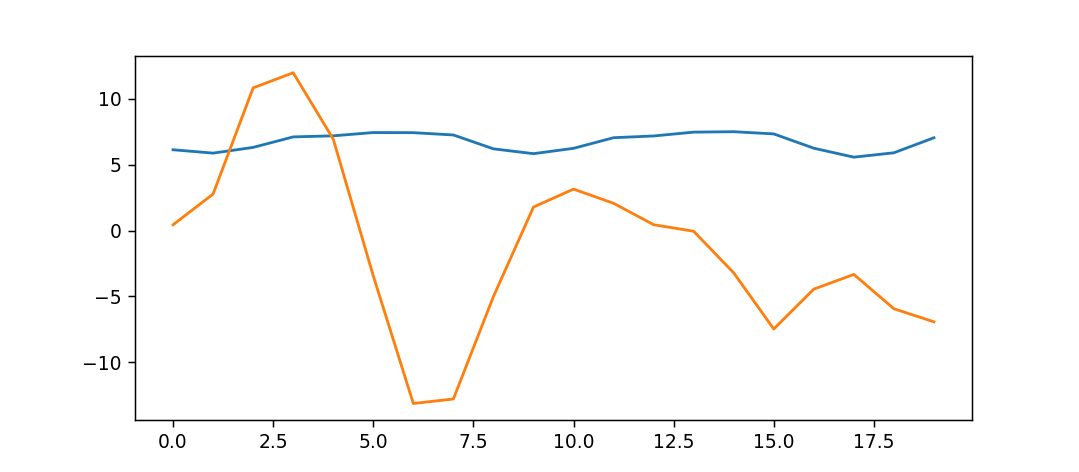

In [193]:
fig = plt.figure()
plt.plot(ave)
plt.plot(tt)
plt.show()

## Evolution

In [187]:
tstat_evo = []
xx = np.arange(tracenum).reshape(-1, step)
binave = DpawsTools.Binave(data_np.shape[1], 1)
for x in xx:
    binave.process(data_np[x], classifiers_np[x].tolist())
    tt = next(binave.ttests())
    tstat_evo.append(tt)
tstat_evo = np.array(tstat_evo)
tstat_evo = np.abs(tstat_evo) # comment out for intermediates
tstat_evo.shape

(10L, 20L)

<IPython.core.display.Javascript object>


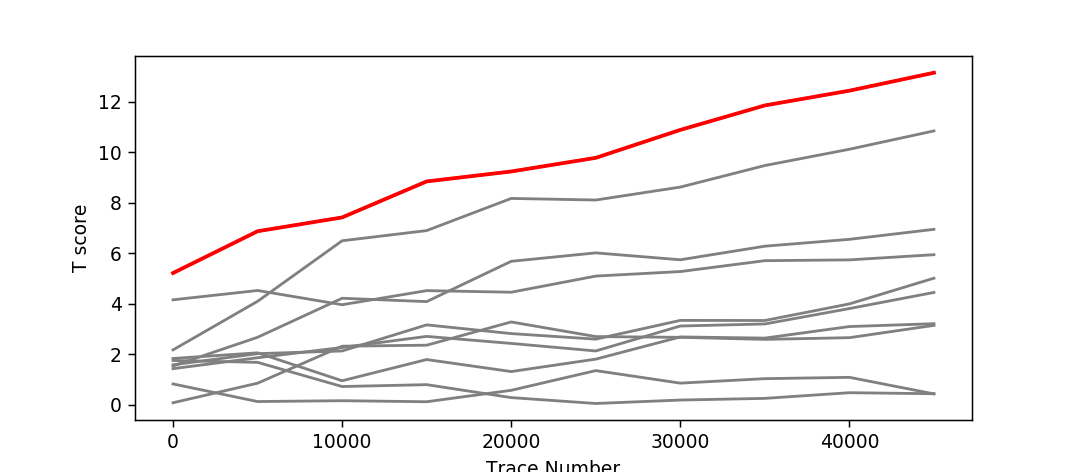

Max leak at: 6


In [189]:
step_num, pt_num = np.shape(tstat_evo)

x_axis = np.arange(step_num) * step

fig = plt.figure()
plt.ylabel('T score')
plt.xlabel('Trace Number')

# Plot leak history for each 2th point 
for j in range(0, pt_num, 2):
    plk = tstat_evo.T[j]
    plt.plot(x_axis, plk, linewidth=1.5, linestyle='-', color = 'grey', zorder = j)

# Max leak point
ml_pt = np.argmax(np.abs(tstat_evo[-1, :])) # max leak point
plt.plot(x_axis, tstat_evo[:, ml_pt], linewidth=2, linestyle='-', color = 'r', zorder=255)

plt.show()

max_leak_pt = ml_pt # store for later
print("Max leak at: {}".format(max_leak_pt))

## Bootstrapping

In [191]:
boots = 205
boot_step = step
upper_bnd = tracenum
t_full_per_step = []
tp_full_per_step = []
tplog_full_per_step = []
for rangenum in range(boot_step, upper_bnd+1, boot_step):
    print("attacking on {} traces".format(rangenum))
    start = time.time()
    t_full, tp_full = [], []
    boot_idxs = np.random.randint(rangenum, size=(boots, rangenum))
    for bi in boot_idxs:
        binave = DpawsTools.Binave(data_np.shape[1], 1)  # always FvR
        binave.process(data_np[bi], classifiers_np[bi].tolist())
        n = binave.count()
        tt_per_boot = next(binave.ttests())              # for all pts do the following:
        t_full.append(tt_per_boot)                         # store tt
        tpv = tdist.sf(tt_per_boot, n)                     # convert tt to pv and store
        tp_full.append(tpv)                                
    t_full_per_step.append(t_full)
    tp_full_per_step.append(tp_full)
    print("Done in {}".format(time.time() - start))
t_full_per_step = np.array(t_full_per_step)
tp_full_per_step = np.array(tp_full_per_step)
# tp_full_per_step[np.where(np.isnan(tp_full_per_step))] = small_value
# tp_full_per_step[np.where(tp_full_per_step < small_value)] = small_value
# tplog_full_per_step = -1.0 * np.log10(tp_full_per_step)

attacking on 5000 traces
Done in 3.05599999428
attacking on 10000 traces
Done in 5.93300008774
attacking on 15000 traces
Done in 8.8140001297
attacking on 20000 traces
Done in 11.132999897
attacking on 25000 traces
Done in 13.7739999294
attacking on 30000 traces
Done in 15.6660001278
attacking on 35000 traces
Done in 19.8740000725
attacking on 40000 traces
Done in 24.9479999542
attacking on 45000 traces
Done in 27.8049998283
attacking on 50000 traces
Done in 34.9650001526


In [199]:
# Find out whether it follows the uniform distribution
ld_stat = stats.uniform
ld_cdf = ld_stat().cdf
ksp_per_step = np.zeros_like(tp_full_per_step[:,1])

for s, bps in enumerate(tp_full_per_step):          # step
    bpsr = bps.T                                    # -> (pt, boot)
    start = time.time()
    print('{}: Step {} ...'.format(bpsr.shape, s))
    for i, ptbt in enumerate(bpsr):
        d, kpv = f.kstest(ptbt, ld_cdf)
        ksp_per_step[s, i] = kpv
    print("Done in {}".format(time.time() - start))


(20L, 205L): Step 0 ...
Done in 0.0100002288818
(20L, 205L): Step 1 ...
Done in 0.00600004196167
(20L, 205L): Step 2 ...
Done in 0.00499987602234
(20L, 205L): Step 3 ...
Done in 0.007000207901
(20L, 205L): Step 4 ...
Done in 0.0130000114441
(20L, 205L): Step 5 ...
Done in 0.0199999809265
(20L, 205L): Step 6 ...
Done in 0.00800013542175
(20L, 205L): Step 7 ...
Done in 0.00699996948242
(20L, 205L): Step 8 ...
Done in 0.00600004196167
(20L, 205L): Step 9 ...
Done in 0.00699996948242


# Bootstrapping vizualization

<IPython.core.display.Javascript object>


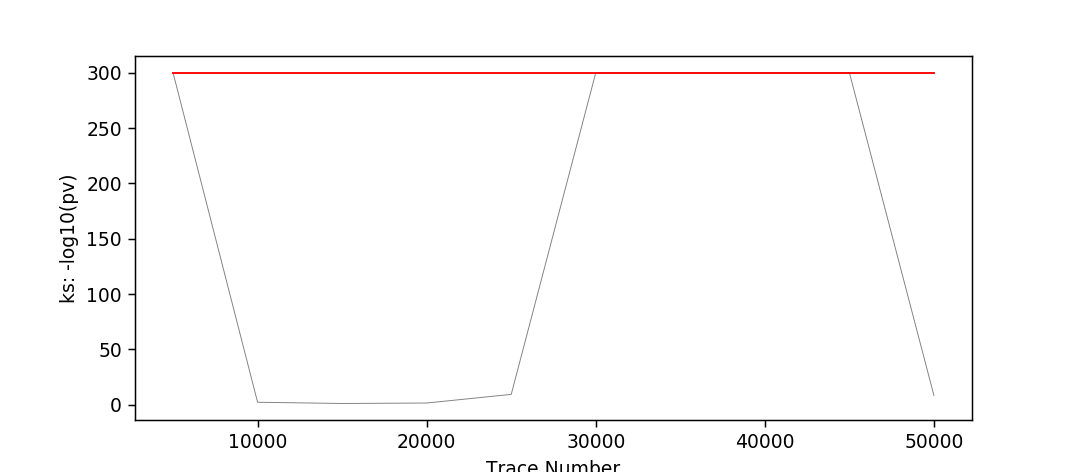

In [205]:
mpi =  max_leak_pt # 15

# Visualization (prepare data)
plot_evo = ksp_per_step.T.copy()
plot_evo[np.where(plot_evo < small_value)] = small_value
pt_num, step_num = np.shape(plot_evo)

x_axis = (np.arange(step_num) + 1) * step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('ks: -log10(pv)')

for j in range(0, pt_num, 20):
    kspl = -np.log10(plot_evo[j])
    plt.plot(x_axis, kspl, linewidth=0.5, color = 'grey', zorder = j)

maxkslpv = -np.log10(plot_evo[mpi])
plt.plot(x_axis, maxkslpv, linewidth=1, color = 'r', zorder=255)

plt.show()
# plot_evo.shape, x_axis.shape

In [21]:
# Debugging 
pb = 3
pi = 20 #byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # kpv = 0
# hwi = 5           # kpv = 0
bootidx = 15
si = 2

bpvs = rp_full_per_step[si].T[pi].reshape(3, 256, -1)[bi]
# print(bpvs[hwi].shape, stats.kstest(bpvs[hwi], ld_cdf))

## Debugging distributions for kstest

<IPython.core.display.Javascript object>


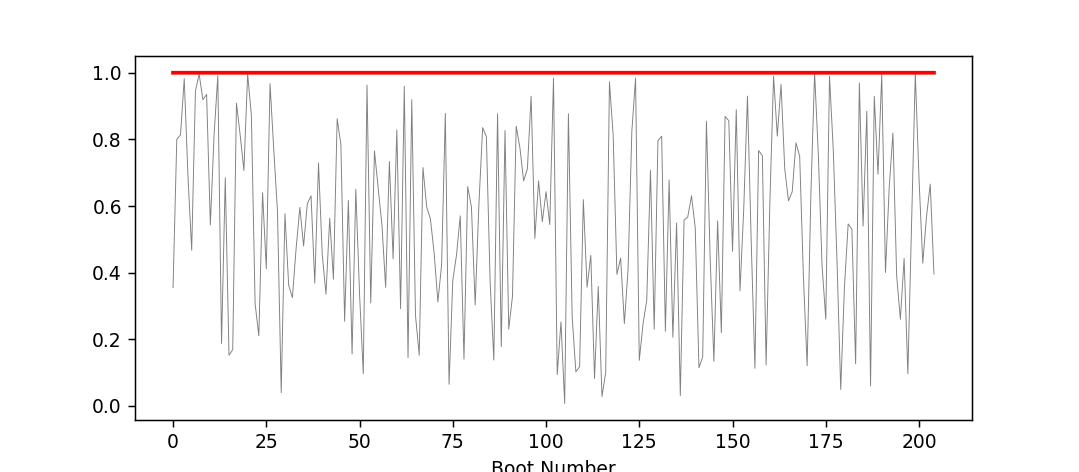

In [198]:

mpi = 6  #max_leak_pt # 178
si = 2

# bpvs = t_full_per_step[si].T  # t
bpvs = tp_full_per_step[si].T   # t-pv

kpvs = []
leak_dist = stats.uniform
# leak_dist = stats.norm
for j in range(0, len(bpvs)):
    bp = bpvs[j]
    d, pv = f.kstest(bp, leak_dist().cdf)
    l, s = leak_dist.fit(bp)      # loc and scale of the dist at the point
    leaking = pv < 0.05           # 3 sigma assurance the point is leaking (non uniform)
    kpvs.append([d, pv, l, s, leaking])
d, pv = f.kstest(bpvs[mpi], leak_dist().cdf)
l, s = leak_dist.fit(bpvs[mpi])  # loc and scale of the dist at the max leak point
leaking = pv < 0.05
kpvs.append([d, pv, l, s, leaking])

# print("d, pv, l, s, leaking")
# print(np.array(kpvs))
    
# norm_cdf = norm(loc=0, scale=1).cdf
# dt, pv  = stats.kstest(bpvs, norm_cdf)

fig = plt.figure()
plt.xlabel('Boot Number')
for j in range(0, len(bpvs), 20):
    plt.plot(bpvs[j], color = 'grey', linewidth=0.5, zorder = j)

plt.plot(bpvs[mpi], color = 'r', linewidth=2, zorder=255)
plt.show()

## Debugging at some boot

In [87]:
%%script false    # This line is to skip this cell as a whole in the real run. Comment to debug a boot step
# rp_full_per_step = []  # rpv
# t_full_per_step = []   # t
# tp_full_per_step = []  # tpv

pb = 0
bootidx = 15

pb = 0
pi = 19 #byte_pt[pb]
bi = byte_idx[pb]
hwi = key_idx[pb]   # kpv = 0

plot_evo = t_full_per_step[:,bootidx,:,pi].reshape(-1, 3, 256)

x_axis = (np.arange(len(plot_evo)) + 1) * step

fig = plt.figure()
plt.xlabel('Trace Number')
plt.ylabel('T score')

hw_num = plot_evo.shape[2]
for j in range(0, hw_num, 4):
    mtt = plot_evo[:, byte_idx[pb], j]
    plt.plot(x_axis, mtt, linewidth=0.5, color = 'grey', zorder = j)
plt.plot(x_axis, plot_evo[:, byte_idx[pb], key_idx[pb]], linewidth=1, color = 'r', zorder=255)

plt.show()


Couldn't find program: u'false'


## Getting familiar with tests 

In [22]:
ud = uniform(loc=0, scale=1)
for i in range(3):
    udrv = ud.rvs(size=1000)
    dk, kpv = stats.kstest(udrv, 'uniform') # H0 - data is uniform
    non_uniform = kpv < 0.05
    print(dk, kpv, non_uniform)

(0.020271580038795922, 0.8057421218625676, False)
(0.022745269469681834, 0.6789656501578599, False)
(0.023398569518338408, 0.6441413299179729, False)


In [23]:
x_100 = norm.rvs(loc=10, scale=1, size=100)
nd = norm(loc=0, scale=1)
for i in range(3):
    ndrv = nd.rvs(size=100)
    dn, npv = stats.kstest(ndrv, 'norm') # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)

(0.07534739432713611, 0.611729704992958, False)
(0.10709947748723764, 0.18763838355660667, False)
(0.06440307825546909, 0.8011954478599529, False)


In [24]:
nd_cdf = norm(loc=10, scale=1).cdf
for i in range(3):
    ndrv = norm.rvs(loc=10, scale=1, size=100)
    dn, npv = stats.kstest(ndrv, nd_cdf) # H0 - data is norm
    non_norm = npv < 0.05
    print(dn, npv, non_norm)

(0.08823838033022063, 0.3976494145631235, False)
(0.10117190205878773, 0.2413044626110159, False)
(0.06960416270738445, 0.7253475529792639, False)


In [25]:
n = 100
a = np.random.random(size=(n, 2)) * 10.0
b = np.random.randint(0, 10, size=(n, 1), dtype=np.uint8)
a[:,0] += b[:,0] / 2.0

bincor = DpawsTools.Bincor(2, 1)
bincor.process(a, b)
rr = np.vstack(bincor.correlation())
pr = np.vstack([r2pv(r, n) for r in rr.copy()])
tt = np.vstack([DpawsTools.FisherTransformation(n, r) for r in rr.copy()])
tt2 = [DpawsTools.FisherTransformation(bincor.count(), _cc) for _c in [rr.copy()] for _cc in _c]
pt = np.vstack([tdist.sf(t1, n) for t1 in tt])

print(rr)
print(tt)
print(tt2)
print(pr) # p-val from r
print(pt) # p-val from t-stat


[[5.206e-01 -2.253e-01]]
[[5.685e+00 -2.258e+00]]
[array([5.685e+00, -2.258e+00])]
[[2.817e-08 2.420e-02]]
[[6.499e-08 9.869e-01]]
